In [3]:
import numpy as np
from numpy import dstack
from numpy import array, dstack
from keras.utils import to_categorical
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from dtaidistance import dtw

In [4]:
trainx_file = "./datatrain_40/total/trainx.txt"
trainy_file = "./datatrain_40/total/trainy.txt"
testx_file = "./datatrain_40/total/testx.txt"
testy_file = "./datatrain_40/total/testy.txt"
config_file = "./datatrain_40/total/config.txt"

In [5]:
def extract_y(file):
    y = []
    for line in file:
        y.append(line)
    y = array(y)
    data = np.vstack(y)
    data.reshape(1,len(y))
    return data

In [6]:
def extract_data(file):
    data = []
    while True:
            try:
                x1 = []
                x2 = []
                x3 = []
                x4 = []
                x5 = []
                x6 = []
                x7 = []
                line = next(file).strip().split()
                if len(line) >= 1680:
                    for i in range(240):
                        x1.append(float(line[i]))
                        x2.append(float(line[i + 240]))
                        x3.append(float(line[i + 480]))
                        x4.append(float(line[i + 720]))
                        x5.append(float(line[i + 960]))
                        x6.append(float(line[i + 1200]))
                        x7.append(float(line[i + 1440]))
                else:
                    print("Error train data.")
                x1 = array(x1)
                x2 = array(x2)
                x3 = array(x3)
                x4 = array(x4)
                x5 = array(x5)
                x6 = array(x6)
                x7 = array(x7)
                line_dataset = dstack([x1, x2, x3, x4, x5, x6, x7]) 
                line_dataset = line_dataset.reshape(1,240,7)
                data.append(line_dataset)
            except StopIteration:
                break
    return data


In [7]:
def readdata(trainx_file, trainy_file, testx_file, testy_file):
    trainx_data =[]
    trainy_data =[]
    testx_data =[]
    testy_data =[]
    with open(trainx_file, 'r') as trainx, open(trainy_file, 'r') as trainy, open(testx_file, 'r') as testx, open(testy_file, 'r') as testy  :
        trainy_data = extract_y(trainy)
        testy_data = extract_y(testy)
        
        trainx_data = extract_data(trainx)
        testx_data = extract_data(testx)

    trainx_data = np.vstack(trainx_data)
    testx_data = np.vstack(testx_data)
    trainy_data = to_categorical(trainy_data)
    testy_data = to_categorical(testy_data)
    return trainx_data, trainy_data, testx_data, testy_data

In [8]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
def evaluate_synthetic_quality(original_df, synthetic_df, max_lag=30):
    """
    Evaluate the quality of synthetic time series data compared to original data.
    
    Parameters:
    original_df (pd.DataFrame): Original time series data
    synthetic_df (pd.DataFrame): Synthetic time series data
    max_lag (int): Maximum lag for autocorrelation calculation (default: 10)
    
    Returns:
    dict: Dictionary containing various evaluation metrics
    """
    metrics = {}
    
    # Input validation
    if original_df.shape != synthetic_df.shape:
        raise ValueError("Original and synthetic dataframes must have the same shape")
    
    # Basic Statistical Metrics
    def calculate_statistical_metrics(orig_data, synt_data):
        try:
            # Convert to numpy arrays for faster computation
            orig_array = np.array(orig_data)
            synt_array = np.array(synt_data)
            
            return {
                'mean_difference': abs(np.mean(orig_array) - np.mean(synt_array)),
                'std_difference': abs(np.std(orig_array) - np.std(synt_array)),
                'ks_test': stats.ks_2samp(orig_array, synt_array).statistic,
                # Only sort once for Wasserstein distance
                'wasserstein': stats.wasserstein_distance(
                    np.sort(orig_array), 
                    np.sort(synt_array)
                )
            }
        except Exception as e:
            print(f"Error in statistical metrics calculation: {str(e)}")
            return None
    
    # Time Series Specific Metrics
    def calculate_ts_metrics(orig_data, synt_data):
        try:
            return {
                'mse': mean_squared_error(orig_data, synt_data),
                'rmse': np.sqrt(mean_squared_error(orig_data, synt_data)),
                'mae': mean_absolute_error(orig_data, synt_data)
            }
        except Exception as e:
            print(f"Error in time series metrics calculation: {str(e)}")
            return None
    
    # Correlation Structure Preservation
    def calculate_correlation_preservation():
        try:
            # Calculate correlations once
            orig_corr = original_df.corr().fillna(0)
            synt_corr = synthetic_df.corr().fillna(0)
            return np.mean(np.abs(orig_corr - synt_corr))
        except Exception as e:
            print(f"Error in correlation preservation calculation: {str(e)}")
            return None
    
    # Autocorrelation Preservation with timeout
    def calculate_autocorr_preservation(orig_data, synt_data):
        try:
            # Pre-calculate autocorrelations
            orig_autocorr = []
            synt_autocorr = []
            
            for i in range(1, min(max_lag + 1, len(orig_data))):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    orig_ac = pd.Series(orig_data).autocorr(lag=i)
                    synt_ac = pd.Series(synt_data).autocorr(lag=i)
                    
                    # Handle NaN values
                    if pd.isna(orig_ac) or pd.isna(synt_ac):
                        continue
                        
                    orig_autocorr.append(orig_ac)
                    synt_autocorr.append(synt_ac)
            
            if not orig_autocorr or not synt_autocorr:
                return 0
                
            return np.mean(np.abs(np.array(orig_autocorr) - np.array(synt_autocorr)))
        except Exception as e:
            print(f"Error in autocorrelation preservation calculation: {str(e)}")
            return None
    
    # Calculate metrics for each column with progress bar
    print("Calculating metrics for each column...")
    for column in tqdm(original_df.columns):
        orig_data = original_df[column].values
        synt_data = synthetic_df[column].values
        
        metrics[column] = {
            'statistical_metrics': calculate_statistical_metrics(orig_data, synt_data),
            'timeseries_metrics': calculate_ts_metrics(orig_data, synt_data),
            'autocorr_preservation': calculate_autocorr_preservation(orig_data, synt_data)
        }
    
    # Overall dataset metrics
    metrics['overall'] = {
        'correlation_preservation': calculate_correlation_preservation(),
        'shape_match': original_df.shape == synthetic_df.shape
    }
    
    return metrics

def print_evaluation_summary(metrics):
    """
    Print a formatted summary of the evaluation metrics.
    
    Parameters:
    metrics (dict): Dictionary of evaluation metrics
    """
    print("\n=== Synthetic Data Quality Evaluation Summary ===\n")
    
    # Print overall metrics
    print("Overall Dataset Metrics:")
    print(f"Shape Match: {metrics['overall']['shape_match']}")
    if metrics['overall']['correlation_preservation'] is not None:
        print(f"Correlation Structure Preservation Score: {metrics['overall']['correlation_preservation']:.4f}")
    print("\nDetailed Metrics by Column:")
    
    # Print column-specific metrics
    for column in metrics.keys():
        if column != 'overall':
            print(f"\n{column}:")
            stats = metrics[column]['statistical_metrics']
            ts = metrics[column]['timeseries_metrics']
            
            if stats:
                print("Statistical Metrics:")
                print(f"  Mean Difference: {stats['mean_difference']:.4f}")
                print(f"  Std Difference: {stats['std_difference']:.4f}")
                print(f"  KS Test Statistic: {stats['ks_test']:.4f}")
                print(f"  Wasserstein Distance: {stats['wasserstein']:.4f}")
            
            if ts:
                print("Time Series Metrics:")
                print(f"  RMSE: {ts['rmse']:.4f}")
                print(f"  MAE: {ts['mae']:.4f}")
            
            if metrics[column]['autocorr_preservation'] is not None:
                print(f"Autocorrelation Preservation Score: {metrics[column]['autocorr_preservation']:.4f}")
                
def visualize_evaluation(original_df, synthetic_df, columns_to_plot=7, max_lag=30):
    """
    Visualize evaluation metrics for synthetic data quality.
    
    Parameters:
    original_df (pd.DataFrame): Original time series data
    synthetic_df (pd.DataFrame): Synthetic time series data
    columns_to_plot (int): Number of columns to visualize (default: 3)
    """
    cols = original_df.columns[:columns_to_plot]
    for col in cols:
        plt.figure(figsize=(14, 6))
        
        # Distribution Comparison
        plt.subplot(1, 3, 1)
        sns.histplot(original_df[col], color='blue', label='Original', kde=True, stat="density")
        sns.histplot(synthetic_df[col], color='red', label='Synthetic', kde=True, stat="density")
        plt.title(f"Distribution Comparison - {col}")
        plt.legend()
        
        # Time Series Comparison

        original = original_df[col].iloc[:250].values
        synthetic = synthetic_df[col].iloc[:250].values

        plt.subplot(1, 3, 2)
        plt.plot(original, label='Original', color='blue')
        plt.plot(synthetic, label='Synthetic', color='red')
        plt.title(f"Time Series Comparison - {col}")
        plt.legend()
        
        # Autocorrelation Comparison
        # plt.subplot(1, 3, 3)
        # orig_autocorr = [original_df[col].autocorr(lag=i) for i in range(1, max_lag + 1)]
        # synt_autocorr = [synthetic_df[col].autocorr(lag=i) for i in range(1, max_lag + 1)]
        # plt.plot(range(1, max_lag + 1), orig_autocorr, label='Original', color='blue')
        # plt.plot(range(1, max_lag + 1), synt_autocorr, label='Synthetic', color='red')
        # plt.title(f"Autocorrelation Comparison - {col}")
        # plt.legend()
        
        plt.tight_layout()
        plt.show()

In [10]:
trainX, trainy, testX, testy = readdata(trainx_file, trainy_file, testx_file, testy_file)
trainy = np.argmax(trainy, axis=1)
class_labels = np.unique(trainy)
# original_data = []
# for label in class_labels:
#     reshaped_data = trainX[trainy == label].reshape(-1 ,7)
#     df = pd.DataFrame(reshaped_data)
#     original_data.append(df)

In [11]:
data_path = "datasource_scaled"
original_data = []
for i in range(len(class_labels)):
    try:
        data = pd.read_csv(f"{data_path}/{i}.csv")
        original_data.append(data)
    except FileNotFoundError:
        print("File not found!")

In [27]:
columns = ['f1', 'f2', 'f3', 'f4', 'gx', 'gy', 'gz']
labels = ["xin chào", "tôi", "tên", "Tiến", "tạm biệt"]

In [28]:
def plot_MSE(metrics, label):
    mse = []
    for key in metrics.keys():
        if key != 'overall':
            ts = metrics[key]['timeseries_metrics']
            if ts:
                mse.append(ts['mse'])
    plt.bar(columns, mse)
    plt.xlabel("Feature")
    plt.ylabel("MSE")
    plt.title(f"MSE for {label}")
    plt.show()

Calculating metrics for each column...


100%|██████████| 7/7 [00:05<00:00,  1.28it/s]



=== Synthetic Data Quality Evaluation Summary ===

Overall Dataset Metrics:
Shape Match: True
Correlation Structure Preservation Score: 0.0225

Detailed Metrics by Column:

f1:
Statistical Metrics:
  Mean Difference: 0.0001
  Std Difference: 0.0061
  KS Test Statistic: 0.0068
  Wasserstein Distance: 0.0023
Time Series Metrics:
  RMSE: 0.1384
  MAE: 0.1052
Autocorrelation Preservation Score: 0.4047

f2:
Statistical Metrics:
  Mean Difference: 0.0018
  Std Difference: 0.0063
  KS Test Statistic: 0.0169
  Wasserstein Distance: 0.0037
Time Series Metrics:
  RMSE: 0.1518
  MAE: 0.1174
Autocorrelation Preservation Score: 0.3709

f3:
Statistical Metrics:
  Mean Difference: 0.0010
  Std Difference: 0.0058
  KS Test Statistic: 0.0153
  Wasserstein Distance: 0.0069
Time Series Metrics:
  RMSE: 0.3955
  MAE: 0.3220
Autocorrelation Preservation Score: 0.4447

f4:
Statistical Metrics:
  Mean Difference: 0.0021
  Std Difference: 0.0017
  KS Test Statistic: 0.0192
  Wasserstein Distance: 0.0029
Time

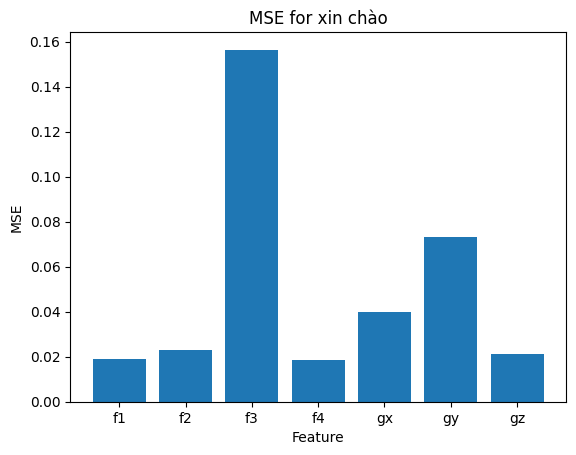




Calculating metrics for each column...


100%|██████████| 7/7 [00:05<00:00,  1.33it/s]



=== Synthetic Data Quality Evaluation Summary ===

Overall Dataset Metrics:
Shape Match: True
Correlation Structure Preservation Score: 0.0271

Detailed Metrics by Column:

f1:
Statistical Metrics:
  Mean Difference: 0.0019
  Std Difference: 0.0192
  KS Test Statistic: 0.0088
  Wasserstein Distance: 0.0031
Time Series Metrics:
  RMSE: 0.0678
  MAE: 0.0408
Autocorrelation Preservation Score: 0.2778

f2:
Statistical Metrics:
  Mean Difference: 0.0031
  Std Difference: 0.0042
  KS Test Statistic: 0.0134
  Wasserstein Distance: 0.0044
Time Series Metrics:
  RMSE: 0.2404
  MAE: 0.1952
Autocorrelation Preservation Score: 0.4491

f3:
Statistical Metrics:
  Mean Difference: 0.0006
  Std Difference: 0.0122
  KS Test Statistic: 0.0132
  Wasserstein Distance: 0.0024
Time Series Metrics:
  RMSE: 0.0525
  MAE: 0.0292
Autocorrelation Preservation Score: 0.3476

f4:
Statistical Metrics:
  Mean Difference: 0.0003
  Std Difference: 0.0010
  KS Test Statistic: 0.0307
  Wasserstein Distance: 0.0020
Time

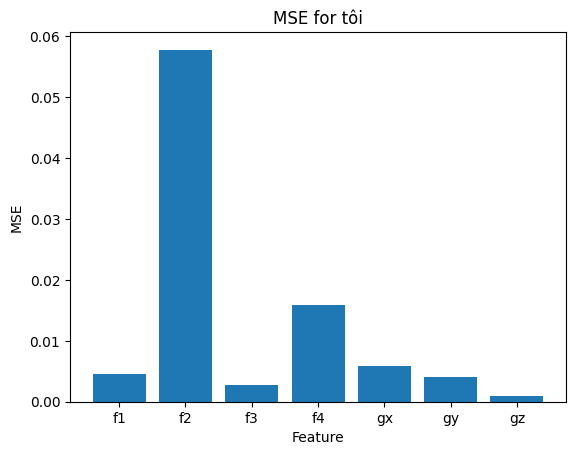




Calculating metrics for each column...


100%|██████████| 7/7 [00:05<00:00,  1.35it/s]



=== Synthetic Data Quality Evaluation Summary ===

Overall Dataset Metrics:
Shape Match: True
Correlation Structure Preservation Score: 0.0177

Detailed Metrics by Column:

f1:
Statistical Metrics:
  Mean Difference: 0.0012
  Std Difference: 0.0055
  KS Test Statistic: 0.0072
  Wasserstein Distance: 0.0026
Time Series Metrics:
  RMSE: 0.1504
  MAE: 0.1146
Autocorrelation Preservation Score: 0.3463

f2:
Statistical Metrics:
  Mean Difference: 0.0013
  Std Difference: 0.0092
  KS Test Statistic: 0.0105
  Wasserstein Distance: 0.0030
Time Series Metrics:
  RMSE: 0.0942
  MAE: 0.0681
Autocorrelation Preservation Score: 0.2041

f3:
Statistical Metrics:
  Mean Difference: 0.0061
  Std Difference: 0.0007
  KS Test Statistic: 0.0141
  Wasserstein Distance: 0.0064
Time Series Metrics:
  RMSE: 0.3361
  MAE: 0.2674
Autocorrelation Preservation Score: 0.2145

f4:
Statistical Metrics:
  Mean Difference: 0.0018
  Std Difference: 0.0034
  KS Test Statistic: 0.0722
  Wasserstein Distance: 0.0021
Time

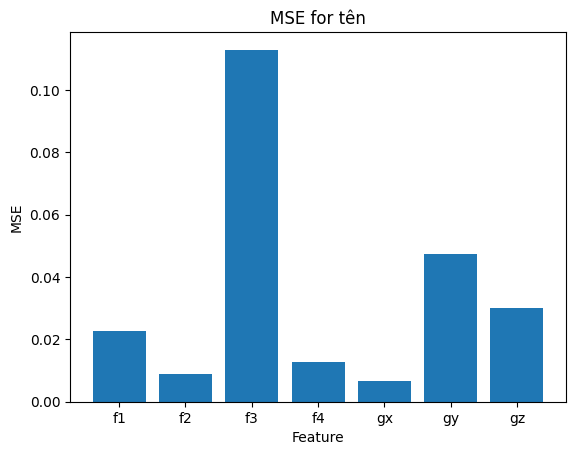




Calculating metrics for each column...


100%|██████████| 7/7 [00:04<00:00,  1.44it/s]


=== Synthetic Data Quality Evaluation Summary ===

Overall Dataset Metrics:
Shape Match: True
Correlation Structure Preservation Score: 0.0311

Detailed Metrics by Column:

f1:
Statistical Metrics:
  Mean Difference: 0.0004
  Std Difference: 0.0034
  KS Test Statistic: 0.0546
  Wasserstein Distance: 0.0005
Time Series Metrics:
  RMSE: 0.0228
  MAE: 0.0093
Autocorrelation Preservation Score: 0.3397

f2:
Statistical Metrics:
  Mean Difference: 0.0001
  Std Difference: 0.0134
  KS Test Statistic: 0.0229
  Wasserstein Distance: 0.0025
Time Series Metrics:
  RMSE: 0.0575
  MAE: 0.0333
Autocorrelation Preservation Score: 0.3056

f3:
Statistical Metrics:
  Mean Difference: 0.0004
  Std Difference: 0.0027
  KS Test Statistic: 0.0994
  Wasserstein Distance: 0.0006
Time Series Metrics:
  RMSE: 0.0235
  MAE: 0.0103
Autocorrelation Preservation Score: 0.3305

f4:
Statistical Metrics:
  Mean Difference: 0.0026
  Std Difference: 0.0000
  KS Test Statistic: 0.0204
  Wasserstein Distance: 0.0028
Time

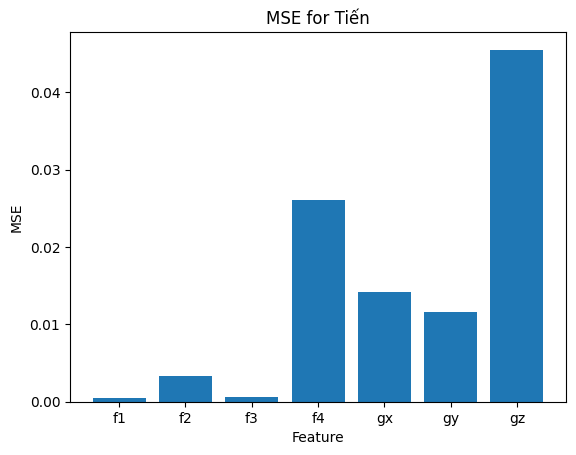




Calculating metrics for each column...


100%|██████████| 7/7 [00:05<00:00,  1.30it/s]



=== Synthetic Data Quality Evaluation Summary ===

Overall Dataset Metrics:
Shape Match: True
Correlation Structure Preservation Score: 0.0266

Detailed Metrics by Column:

f1:
Statistical Metrics:
  Mean Difference: 0.0020
  Std Difference: 0.0187
  KS Test Statistic: 0.0127
  Wasserstein Distance: 0.0032
Time Series Metrics:
  RMSE: 0.0560
  MAE: 0.0337
Autocorrelation Preservation Score: 0.2331

f2:
Statistical Metrics:
  Mean Difference: 0.0009
  Std Difference: 0.0114
  KS Test Statistic: 0.0181
  Wasserstein Distance: 0.0025
Time Series Metrics:
  RMSE: 0.0616
  MAE: 0.0409
Autocorrelation Preservation Score: 0.2600

f3:
Statistical Metrics:
  Mean Difference: 0.0013
  Std Difference: 0.0057
  KS Test Statistic: 0.0114
  Wasserstein Distance: 0.0051
Time Series Metrics:
  RMSE: 0.2703
  MAE: 0.2199
Autocorrelation Preservation Score: 0.4466

f4:
Statistical Metrics:
  Mean Difference: 0.0050
  Std Difference: 0.0043
  KS Test Statistic: 0.0341
  Wasserstein Distance: 0.0055
Time

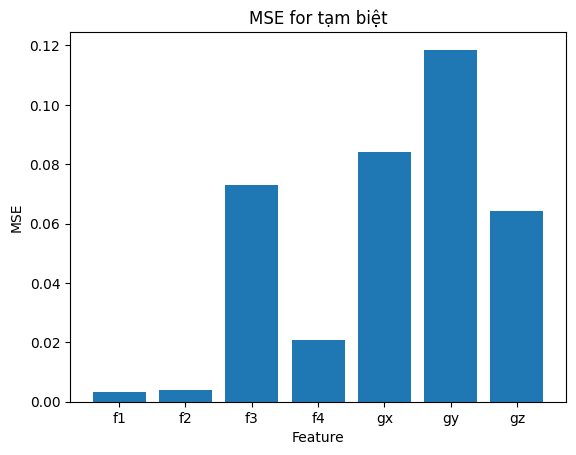

In [29]:
synthetic_path = "synthetic_data_scaled"



for i in range(len(class_labels)):
    try:
        synthetic_data = pd.read_csv(f"{synthetic_path}/{i}.csv")
        # print(original_data[i].shape, synthetic_data.shape)
        # print(original_data[i].head())
        # print(synthetic_data.head())  
        metrics = evaluate_synthetic_quality(original_data[i], synthetic_data)
        print_evaluation_summary(metrics)
        plot_MSE(metrics, labels[i])
        # visualize_evaluation(original_data[i], synthetic_data)
        print("\n\n")
    except FileNotFoundError:
        print("File not found!")